<a href="https://colab.research.google.com/github/marquito3012/TFG/blob/main/FineTuningActionClasificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="9KG8ovuhVxeymK6aMBor")
project = rf.workspace("uni-mallw").project("drowsy-detection-qnv9b")
version = project.version(3)
dataset = version.download("yolov5pytorch")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Drowsy-Detection-3 in yolov5pytorch:: 100%|██████████| 3605/3605 [00:00<00:00, 3656.91it/s]


In [ ]:
import os
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

class YOLODataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        while True: # Loop until a valid image is found
            img_name = self.image_files[idx]
            img_path = os.path.join(self.image_dir, img_name)
            label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt'))

            #print("Image_name: " + img_name)
            #print("Image path " + img_path)
            #print("Label path " + label_path)

            image = Image.open(img_path).convert("RGB")

            # Load YOLO format labels (class_id, x_center, y_center, width, height)
            with open(label_path, 'r') as f:
                label = str(f.readlines())
            #print("Label: " + label)

            if label == "[]":
              idx = (idx + 1) % len(self)  # Move to the next image
              continue  # Skip this image

            # Extract the class ID (first value in each line)
            class_id = int(label.strip("[']").split()[0])
            #print("Class id: " + str(class_id))


            target = torch.tensor(class_id, dtype=torch.long)  # Single-class classification

            if self.transform:
                image = self.transform(image)

            return image, target

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset and dataloader
train_dataset = YOLODataset(
    image_dir=os.path.join(dataset.location, "train", "images"),
    label_dir=os.path.join(dataset.location, "train", "labels"),
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create dataset and dataloader for test data
test_dataset = YOLODataset(
    image_dir=os.path.join(dataset.location, "valid", "images"),
    label_dir=os.path.join(dataset.location, "valid", "labels"),
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle test data

In [ ]:
import torchvision.models as models

# Load a pre-trained model (e.g., ResNet50)
model = models.resnet50(weights="IMAGENET1K_V2")

# Modify the final layer to match the number of classes in your dataset
num_classes = 2  # Get the number of classes from the dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.6MB/s]


In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import torch.nn.functional as F

num_epochs = 10

import matplotlib.pyplot as plt
# Initialize lists to store metrics for training
train_losses = [] # total losses in training
train_accuracies = [] # accuracies in training
test_accuracies = [] # accuracies in testing


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0 # number of correct predictions

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Calculate the loss using CrossEntropyLoss
        loss = criterion(outputs, labels.long())

        # For accuracy calculation
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_corrects.double() / len(train_dataset) *100 # accuracy in percentage

    # Store metrics for plotting later
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)


    print(f"TRAINING DATA - Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Evaluate the model
    correct = 0
    total = 0

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    print(f"TEST DATA Accuracy: {test_accuracy:.2f}%")

TRAINING DATA - Epoch [1/10], Loss: 0.4543, Accuracy: 77.60%
TEST DATA Accuracy: 89.98%
TRAINING DATA - Epoch [2/10], Loss: 0.2439, Accuracy: 89.99%
TEST DATA Accuracy: 91.09%
TRAINING DATA - Epoch [3/10], Loss: 0.2112, Accuracy: 93.65%
TEST DATA Accuracy: 90.72%
TRAINING DATA - Epoch [4/10], Loss: 0.1408, Accuracy: 95.31%
TEST DATA Accuracy: 91.65%
TRAINING DATA - Epoch [5/10], Loss: 0.0976, Accuracy: 97.14%
TEST DATA Accuracy: 91.47%
TRAINING DATA - Epoch [6/10], Loss: 0.0993, Accuracy: 96.82%
TEST DATA Accuracy: 93.88%
TRAINING DATA - Epoch [7/10], Loss: 0.0556, Accuracy: 98.01%
TEST DATA Accuracy: 94.99%
TRAINING DATA - Epoch [8/10], Loss: 0.0874, Accuracy: 96.82%
TEST DATA Accuracy: 92.76%
TRAINING DATA - Epoch [9/10], Loss: 0.1119, Accuracy: 96.03%
TEST DATA Accuracy: 93.88%
TRAINING DATA - Epoch [10/10], Loss: 0.0551, Accuracy: 98.17%
TEST DATA Accuracy: 95.18%


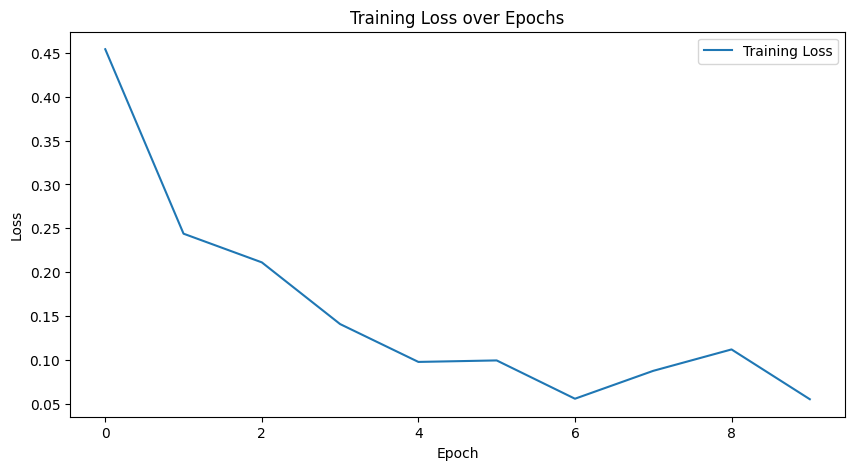

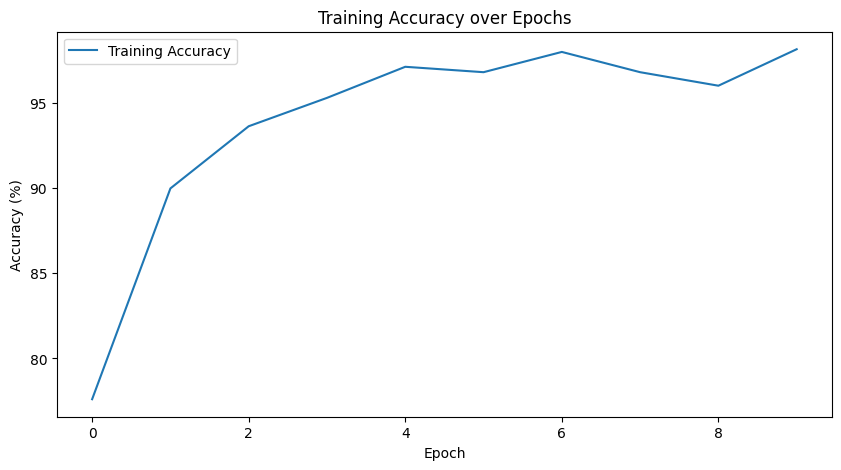

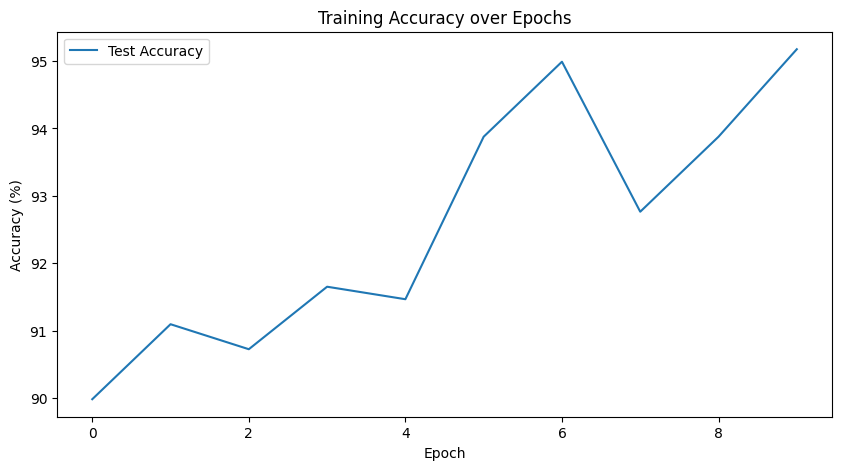

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

import numpy as np  # Import numpy

plt.figure(figsize=(10, 5))

# Convert train_accuracies to a list of NumPy arrays
train_accuracies_cpu = [acc.cpu().detach().numpy() for acc in train_accuracies]

plt.plot(train_accuracies_cpu, label="Training Accuracy")  # Plot using the converted data
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), "fine_tuned_model.pth")